In [4]:
import numpy as np
# Calculate the gini coefficient
def gini(x):
    """
    Calculate the Gini coefficient of a numpy array.

    Parameters:
    x (numpy array): The array with the values, wher
    """
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [5]:
mushrroms = {
    'CoTAgent': {
        'gpt4o_mini': [
            {'Juan': 20, 'Bot': 15},
            {'Juan': 45, 'Bot': -6},
            {'Juan': 41, 'Bot': 16},
            {'Juan': 50, 'Bot': 6},
            {'Juan': 25, 'Bot': 13},
            {'Juan': -13, 'Bot': 47},
            {'Juan': 17, 'Bot': 24},
            {'Juan': 35, 'Bot': 17},
            {'Juan': 36, 'Bot': 13},
            {'Juan': 18, 'Bot': 12}],
        'gpt4o': [
            {'Juan': 60, 'Bot': 15},
            {'Juan': -12, 'Bot': 13},
            {'Juan': 26, 'Bot': 2},
            {'Juan': 29, 'Bot': 17},
            {'Juan': 11, 'Bot': 8},
            {'Juan': 14, 'Bot': 30},
            {'Juan': 29, 'Bot': 17},
            {'Juan': 60, 'Bot': -5},
            {'Juan': -5, 'Bot': 32},
            {'Juan': 12, 'Bot': 37}]
        },
 'GenerativeAgents': {
    'gpt4o_mini': [
        {'Juan': 36, 'Bot': 32},
        {'Juan': 33, 'Bot': 27},
        {'Juan': 37, 'Bot': 3},
        {'Juan': 43, 'Bot': 30},
        {'Juan': -9, 'Bot': 10},
        {'Juan': 11, 'Bot': 6},
        {'Juan': 50, 'Bot': 20},
        {'Juan': 28, 'Bot': 31},
        {'Juan': 47, 'Bot': 21},
        {'Juan': 36, 'Bot': 22}],
    'gpt4o': [
        {'Juan': 54, 'Bot': 1},
        {'Juan': 34, 'Bot': 4},
        {'Juan': 42, 'Bot': 21},
        {'Juan': 16, 'Bot': 18},
        {'Juan': 48, 'Bot': 14},
        {'Juan': 57, 'Bot': 23},
        {'Juan': 28, 'Bot': 11},
        {'Juan': 14, 'Bot': 18},
        {'Juan': 27, 'Bot': 20},
        {'Juan': 18, 'Bot': 18}]
    }
}

In [6]:
def get_indicator_by_simulation(indicators, indicator_name):
    """
    Returns a list with the value of the indicator scpecified for each simulation
    """
    return [sim[indicator_name] if indicator_name in sim else {} for sim in indicators]

def get_results_by_category_and_subcategory(indicators, llm_model, indicator_name, categories, agg_fn):
    """
    Returns a dictionary with the categories as keys and as values a dictionary with the subcategories as keys and a list 
    with the values for each simulation

    Parameters:
    indicators (dict): The indicators dictionary
    llm_model (str): The LLM model
    indicator_name (str): The name of the indicator
    categories (list): The name of the categories
    agg_fn (function): The function to aggregate the values for the agents
    """
    subcategories = list(indicators.keys())

    if indicator_name:
        subcategories_results = {subcat: get_indicator_by_simulation(indicators[subcat][llm_model], indicator_name) for subcat in subcategories}
    else:
        subcategories_results = {subcat: indicators[subcat][llm_model] for subcat in subcategories}
    
    # If there are no categories, return the results by subcategory
    if not categories:
        results = {}
        for subcat in subcategories:
            results[subcat] = agg_fn(subcategories_results[subcat], None)
        return results

    results_by_cat = {}
    for cat in categories:
        results_by_cat[cat] = {}
        for subcat in subcategories:
            results_by_cat[cat][subcat] = agg_fn(subcategories_results[subcat], cat)
    return results_by_cat

def take_cat_result(actions_indicator_by_sim, category):
        # If there is no category, return the results for Juan
        if category is None:
                return actions_indicator_by_sim

        return [sim[category] if category in sim else 0 for sim in actions_indicator_by_sim]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors for the generative agents architecture and the CoT architecture
SUBCAT_COLORS = [{'facecolor': 'lightblue', 'color': 'blue'},
    {'facecolor': 'lightgreen', 'color': 'green'}
]

def create_box_plot(results, subcat_colors, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    try:
        subcategories = list(results[categories[0]].keys())

    except:
        # If there are is an exception is because the data has no categories
        subcategories = categories
        categories = None
    if kwargs.get('custom_subcats', None):
        subcat_names = kwargs['custom_subcats']
    else:
        subcat_names = subcategories
        

    if norm_across_cats and categories is not None:
        results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations
        # Mask to avoid division by zero
        mask = results.sum(axis=0, keepdims=True) == 0
        results = results/(results.sum(axis=0, keepdims=True)+mask)

    if categories is None:
        positions = np.arange(len(subcategories))+1
    else:
        positions = np.arange(len(categories)*len(subcategories))+1
    positions = positions*0.2

    for s, subcategory in enumerate(subcategories):
        boxprops = subcat_colors[s].copy()
        if categories is not None:
            if norm_across_cats:
                data = [results[c][s] for c in range(len(categories))]
            else:
                data = [results[c][subcategory] for c in categories]
        else:
            # data = results[s]
            data = results[subcategory]
        plt.boxplot(data, positions=positions[s::len(subcategories)], patch_artist=True, boxprops=boxprops, showmeans=True, widths=0.1)

    if categories is not None:
        plt.xticks(positions[::len(subcategories)], categories)
    else:
        plt.xticks(positions, subcat_names)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])

    if categories is not None:
        legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                                label=subcategory) for i, subcategory in enumerate(subcat_names)]
        plt.legend(handles=legend_elements, loc='upper right')
    
    # rotate x labels
    if kwargs.get('rotated_labels', False):
        plt.xticks(rotation=45)

In [50]:
agents = ['Juan', 'Bot']
reward_by_agent_by_arch = get_results_by_category_and_subcategory(mushrroms, 'gpt4o_mini', None, agents, take_cat_result)

In [51]:
reward_by_agent_by_arch

{'Juan': {'CoTAgent': [20, 45, 41, 50, 25, -13, 17, 35, 36, 18],
  'GenerativeAgents': [36, 33, 37, 43, -9, 11, 50, 28, 47, 36]},
 'Bot': {'CoTAgent': [15, -6, 16, 6, 13, 47, 24, 17, 13, 12],
  'GenerativeAgents': [32, 27, 3, 30, 10, 6, 20, 31, 21, 22]}}

In [52]:
gini_coefs1 = []
reward_by_agent_arch1 = [agent_result['GenerativeAgents'] for agent_result in reward_by_agent_by_arch.values()]
for sim in range(len(reward_by_agent_arch1[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch1]
    gini_coefs1.append(gini(rewards_by_agent))

gini_coefs2 = []
reward_by_agent_arch2 = [agent_result['CoTAgent'] for agent_result in reward_by_agent_by_arch.values()]
for sim in range(len(reward_by_agent_arch2[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch2]
    gini_coefs2.append(gini(rewards_by_agent))

gini_coefs_by_arch = {'GenAgents': gini_coefs1, 'CoTAgents': gini_coefs2}

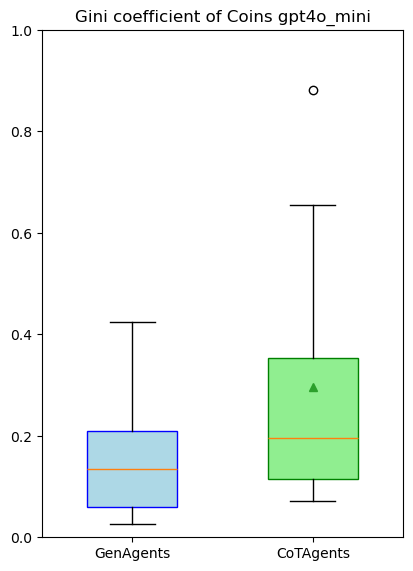

In [56]:
create_box_plot(gini_coefs_by_arch, SUBCAT_COLORS, title='Gini coefficient of Coins gpt4o_mini')
plt.ylim(0, 1)
plt.xlim(0.1, 0.5)
# Make layout more compact
plt.tight_layout()
# Reduce the width of the plot
plt.gcf().set_size_inches(4, 6)
plt.show()

In [15]:
gini_coefs_by_arch

{'GenAgents': [0.029411764705882353,
  0.05,
  0.425,
  0.08904109589041095,
  9.5,
  0.14705882352941177,
  0.21428571428571427,
  0.025423728813559324,
  0.19117647058823528,
  0.1206896551724138],
 'CoTAgents': [0.07142857142857142,
  0.6538461538461539,
  0.21929824561403508,
  0.39285714285714285,
  0.15789473684210525,
  0.8823529411764706,
  0.08536585365853659,
  0.17307692307692307,
  0.23469387755102042,
  0.1]}